# WGCNA
Putting WGCNA analyses into a Jupyter notebook for annotation. Bear with me through some of the dataframe manipulations, I find R much less intuitive than Python.

In [8]:
options(warn=-1)

In [9]:
# install.packages(c("matrixStats", "Hmisc", "splines", "foreach", "doParallel", "fastcluster", "dynamicTreeCut", "survival"))
# BiocManager::install(c("WGCNA", "GO.db", "preprocessCore", "impute"))

In [10]:
pkgs = c("WGCNA", "statmod", "stringr", "dplyr", "tidyr", "reshape2", "flastclust", "corrr")
lapply(pkgs, require, character.only=TRUE)

theme_set(theme_minimal())
theme_update(axis.line = element_line(color = "black"), axis.ticks = element_line(color="black"))
allowWGCNAThreads()
options(stringsAsFactors = FALSE)

Loading required package: flastclust



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] FALSE

[[8]]
[1] TRUE

ERROR: Error in theme_set(theme_minimal()): could not find function "theme_set"


I'll be following these two pages from [Wisconsen](http://pages.stat.wisc.edu/~yandell/statgen/ucla/WGCNA/wgcna.html) and [Texas](https://wikis.utexas.edu/display/bioiteam/Clustering+using+WGCNA?preview=/104465671/163879871/WGCNA2017.pdf)

## Data input and cleaning

In [11]:
sleuthData = read.csv("../Network-analysis/P-oleracea-unigene-norm-filt.WGCNA.csv")
# sample_names = sleuthData[,1]

Now for the metadata.

In [4]:
Poleracea_metadata = read.csv("../Abun/P-oleracea.metadata.csv")
sleuthData$time_point = Poleracea_metadata$time_point
sleuthData$color = Poleracea_metadata$hex_color
sleuthData$treatment = Poleracea_metadata$treatment
names(sleuthData)[names(sleuthData) == "X"] = "sample"

In [5]:
sleuthData[1:10,1:10]

,sequencer_name,TRINITY_DN0_c0_g1,TRINITY_DN0_c0_g2,TRINITY_DN100001_c0_g1,TRINITY_DN100003_c0_g1,TRINITY_DN100003_c0_g2,TRINITY_DN100003_c1_g2,TRINITY_DN100007_c0_g1,TRINITY_DN10000_c0_g1,TRINITY_DN10000_c0_g2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P-oleracea-F_001_186_007,600.3311,96.75749,71.17958,9.952105,6.1901809,6.730559,3.8381528,3.6823860,0.000000
2,P-oleracea-F_005_138_055,728.6229,118.08371,104.74765,6.907088,3.8202676,9.175735,19.4493815,0.0000000,0.000000
3,P-oleracea-F_011_161_032,281.9700,87.61250,28.95020,16.085907,3.7933234,17.048873,1.1081535,3.9754959,1.012237
4,P-oleracea-F_013_137_056,791.2810,120.08349,98.45075,6.602004,1.1154338,12.243434,37.8655868,3.3106510,3.252900
5,P-oleracea-F_014_125_068,426.3525,113.38567,30.04717,5.705849,0.8966846,12.992884,0.9751821,0.9086349,0.000000
6,P-oleracea-F_016_101_092,344.6096,91.82384,31.17031,8.591473,0.2314726,18.397754,1.2586207,5.7435807,1.152463
7,P-oleracea-F_024_100_093,610.5657,56.66597,131.89364,1.083290,0.0000000,3.741570,8.7238635,5.4461581,0.000000
8,P-oleracea-F_026_171_022,307.4545,72.32707,48.58221,2.424847,0.7147763,3.821987,3.6282193,4.7067707,0.000000
9,P-oleracea-F_030_123_070,281.6447,22.64438,38.30204,2.639655,0.0000000,7.335668,1.9893858,2.6888581,0.000000


Now I'll split the data into well-watered and drought, and apply a couple filters that remove lowly expressed or low varaince genes, as well as outliers from each dataset.

In [6]:
wwData = sleuthData[sleuthData$treatment=="W",]
dData = sleuthData[sleuthData$treatment=="D",]
dData$time_point = dData$time_point %% 4

In [18]:
Poleracea_metadata[Poleracea_metadata$treatment=="W","sample"]

[1] P-oleracea_001 P-oleracea_005 P-oleracea_011 P-oleracea_013 P-oleracea_014
 [6] P-oleracea_016 P-oleracea_024 P-oleracea_026 P-oleracea_030 P-oleracea_031
[11] P-oleracea_032 P-oleracea_035 P-oleracea_038 P-oleracea_043 P-oleracea_046
[16] P-oleracea_049 P-oleracea_050 P-oleracea_051 P-oleracea_059 P-oleracea_062
[21] P-oleracea_064 P-oleracea_068 P-oleracea_069 P-oleracea_072
44 Levels: P-oleracea_001 P-oleracea_005 P-oleracea_011 ... P-oleracea_142

In [19]:
wwExp = wwData[, grepl("TRINITY", names(wwData))]
pass_filter = apply(wwExp, 2, max) >= 5
wwExp = wwExp[,pass_filter]
rownames(wwExp)= Poleracea_metadata[Poleracea_metadata$treatment=="W","sample"]
dim(wwExp)
wwExp[1:10,1:10]

[1]    24 91408

,TRINITY_DN0_c0_g1,TRINITY_DN0_c0_g2,TRINITY_DN100001_c0_g1,TRINITY_DN100003_c0_g1,TRINITY_DN100003_c0_g2,TRINITY_DN100003_c1_g2,TRINITY_DN100007_c0_g1,TRINITY_DN10000_c0_g1,TRINITY_DN10000_c0_g2,TRINITY_DN10001_c10_g1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P-oleracea_001,600.3311,96.75749,71.17958,9.952105,6.1901809,6.730559,3.8381528,3.6823860,0.000000,233.31817
P-oleracea_005,728.6229,118.08371,104.74765,6.907088,3.8202676,9.175735,19.4493815,0.0000000,0.000000,238.61886
P-oleracea_011,281.9700,87.61250,28.95020,16.085907,3.7933234,17.048873,1.1081535,3.9754959,1.012237,220.66775
P-oleracea_013,791.2810,120.08349,98.45075,6.602004,1.1154338,12.243434,37.8655868,3.3106510,3.252900,179.99380
P-oleracea_014,426.3525,113.38567,30.04717,5.705849,0.8966846,12.992884,0.9751821,0.9086349,0.000000,248.69941
P-oleracea_016,344.6096,91.82384,31.17031,8.591473,0.2314726,18.397754,1.2586207,5.7435807,1.152463,206.29082
P-oleracea_024,610.5657,56.66597,131.89364,1.083290,0.0000000,3.741570,8.7238635,5.4461581,0.000000,116.09534
P-oleracea_026,307.4545,72.32707,48.58221,2.424847,0.7147763,3.821987,3.6282193,4.7067707,0.000000,94.37330
P-oleracea_030,281.6447,22.64438,38.30204,2.639655,0.0000000,7.335668,1.9893858,2.6888581,0.000000,78.71416


In [20]:
dExp = dData[, grepl("TRINITY", names(dData))]
pass_filter = apply(dExp, 2, max) >= 5
dExp = dExp[,pass_filter]
rownames(dExp)= Poleracea_metadata[Poleracea_metadata$treatment=="D","sample"]
dim(dExp)
dExp[1:10,1:10]

[1]     20 105445

,TRINITY_DN0_c0_g1,TRINITY_DN0_c0_g2,TRINITY_DN100001_c0_g1,TRINITY_DN100003_c0_g1,TRINITY_DN100003_c1_g2,TRINITY_DN100007_c0_g1,TRINITY_DN10000_c0_g1,TRINITY_DN10000_c0_g2,TRINITY_DN10001_c0_g1,TRINITY_DN10001_c10_g1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P-oleracea_097,300.6411,68.86501,14.27347,1.8928098,3.888338,2.000456,3.669626,5.5025982,1.7513546,207.7647
P-oleracea_099,493.5988,106.39445,32.48437,0.0000000,0.000000,0.000000,7.011149,5.2567095,0.0000000,157.7013
P-oleracea_101,811.5637,136.32909,36.92720,0.4916772,3.938785,1.606517,8.833885,2.9436940,4.5811190,145.7129
P-oleracea_105,622.1644,72.15225,14.04787,2.4882115,9.978257,3.139142,6.450866,0.7206351,0.6957305,135.4794
P-oleracea_108,401.3369,88.99823,12.29937,4.5186495,4.149211,0.000000,6.691356,1.3425795,2.5950774,231.9962
P-oleracea_111,213.0887,14.41762,24.58400,6.2961354,0.000000,1.481060,12.300635,5.4327185,0.0000000,132.2209
P-oleracea_112,301.9148,14.48168,37.08184,0.4833820,0.000000,0.000000,11.031509,5.5870005,1.5194036,113.1368
P-oleracea_113,185.3836,16.97132,19.11079,3.7805980,3.400880,0.000000,13.181121,7.5859377,0.0000000,144.7706
P-oleracea_117,278.3776,18.71477,13.77305,0.6028728,0.000000,0.000000,2.391867,2.4336502,1.1623483,111.0890


In [21]:
length(intersect(colnames(wwExp), colnames(dExp)))/length(union(colnames(wwExp), colnames(dExp)))

[1] 0.7131059

The well-watered contains 91,408 genes, and the drought set contains 105,445, both are only slightly down from the ininital 114k genes. These two datasets largely overlap (~71%), but that does mean that thousands of genes differ between the two. The function `goodSamplesGenes` will flag genes with too low variance or that are outliers.

In [22]:
ww_gsg = goodSamplesGenes(datExpr = wwExp, verbose = 3)
ww_gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

So no genes were removed from the well-watered dataset, now on to the drought samples.

In [23]:
d_gsg = goodSamplesGenes(datExpr = dExp, verbose = 3)
d_gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

No genes were removed here either, so we're on to the final filtering step: removing entire samples that are outliers. We'll do this by hierarchically clustering our samples and cuttinng branches from the resulting tree.

In [24]:
wwSampleTree = hclust(dist(wwExp), method = "average")
dSampleTree = hclust(dist(dExp), method = "average")

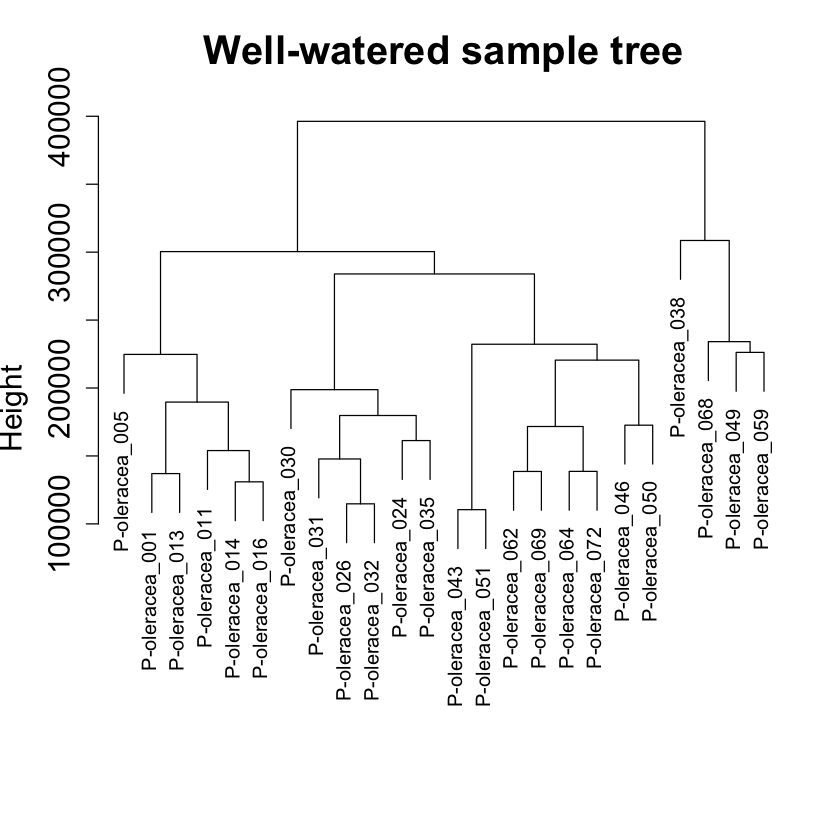

In [25]:
plot(wwSampleTree, main = "Well-watered sample tree", sub="", xlab="", cex.lab=1.5, cex.axis=1.5, cex.main=2)

So no obvious outliers in the well-watered data.

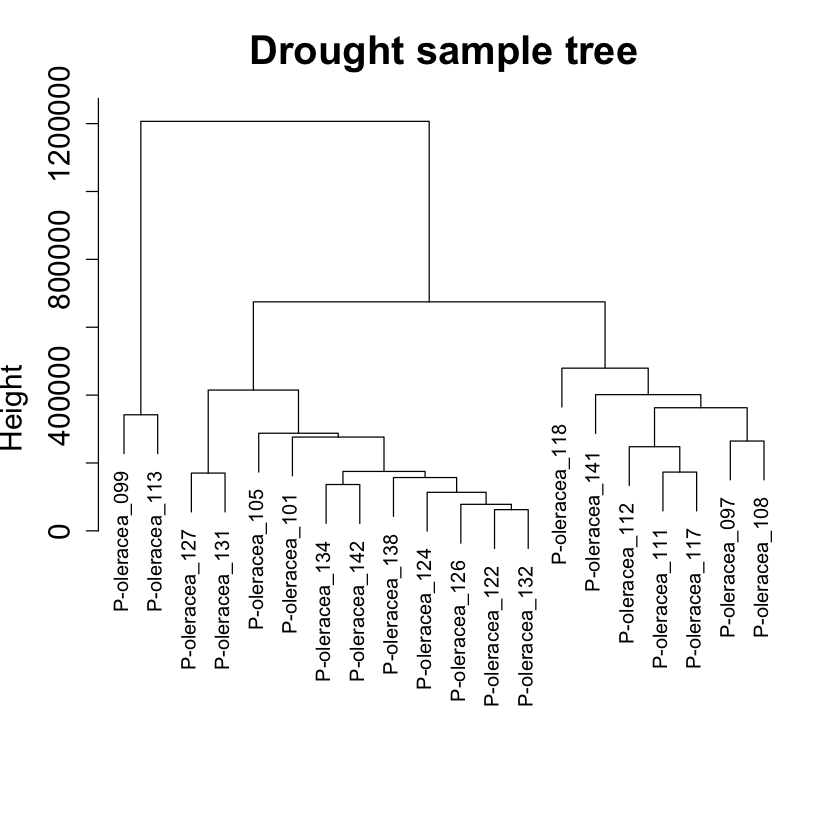

In [34]:
plot(dSampleTree, main = "Drought sample tree", sub="", xlab="", cex.lab=1.5, cex.axis=1.5, cex.main=2)

It doesn't look like there are obvious outliers here either.

In [35]:
wwNGenes = ncol(wwExp)
wwNSamples = nrow(wwExp)
dNGenes = ncol(dExp)
dNSamples = nrow(dExp)
dim(wwExp)
dim(dExp)

[1]    24 91408

[1]     20 105445

In [36]:
rownames(wwData) = wwData$sample
rownames(dData) = dData$sample

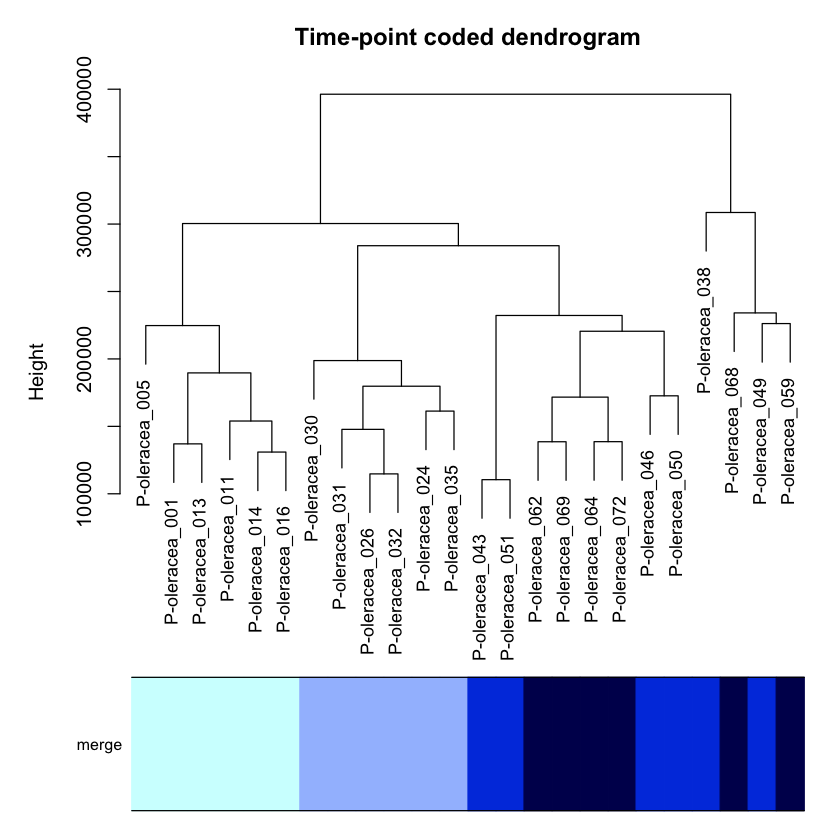

In [37]:
wwMetaTree = hclust(dist(wwExp), method = "average")
plotDendroAndColors(dendro = wwMetaTree, colors = wwData$color, groupLabels = names(wwMetaTree),
                    main = "Time-point coded dendrogram")

In the figure above, the colors represent time points from earliest (lightest blue) to latest (darkest blue). Besides the morning samples, each time point does not form it's own cluster.

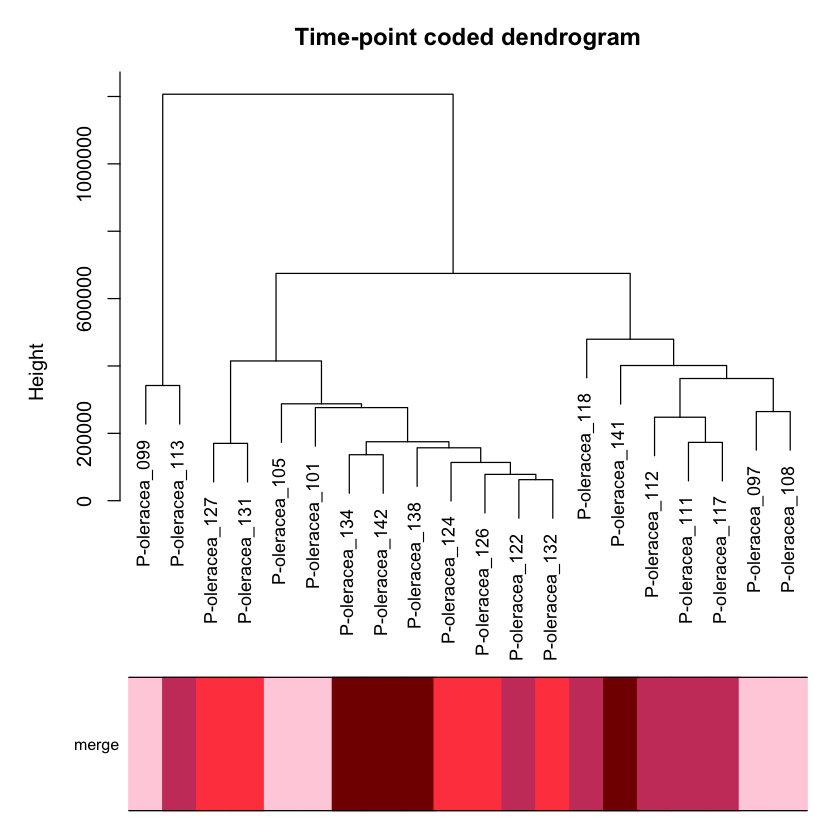

In [38]:
dMetaTree = hclust(dist(dExp), method = "average")
plotDendroAndColors(dendro = dMetaTree, colors = dData$color, groupLabels = names(dMetaTree),
                    main = "Time-point coded dendrogram")

The pattern for the drought data is similar. I'll save some of the more important data structures so they can be easily loaded in the future.

In [41]:
# save(Poleracea_metadata, sleuthData, wwExp, dExp, file = "../Network-analysis/WCGNA/P-oleracea-Expr.genes.RData")

In [2]:
load("../Network-analysis/WGCNA/P-oleracea-Expr.genes.RData")

## Network connstruction and module detection
In order to use the `blockwiseModules` function that automatically creates the network and detect modules, we first need to determine the soft threshold powers that render our networks [scale free](https://en.wikipedia.org/wiki/Scale-free_network). Because these networks are substantially larger than the _P. amilis_ data, I'm going to do much of the remaining work on the cluster, but I'll document it all here.

In [40]:
# powers = c(c(1:10), seq(from = 12, to = 16, by = 2))
# wwSft = pickSoftThreshold(data = wwExp, powerVector = powers, verbose = 5, blockSize = 5000)
# dSft = pickSoftThreshold(data = dExp, powerVector = powers, verbose = 5, blockSize = 5000)

 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5000 of 91408


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


```R
> wwSft = pickSoftThreshold(data = wwExp, powerVector = powers, verbose = 5, blockSize=30000)
  pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 30000 of 91408
   ..working on genes 30001 through 60000 of 91408
   ..working on genes 60001 through 90000 of 91408
   ..working on genes 90001 through 91408 of 91408
   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0222  0.51          0.888 22600.0   22300.0  36600
2      2   0.2740 -1.10          0.900  8510.0    8020.0  19700
3      3   0.5390 -1.55          0.914  3950.0    3480.0  12100
4      4   0.6370 -1.79          0.921  2090.0    1700.0   8090
5      5   0.6820 -1.94          0.925  1210.0     906.0   5710
6      6   0.6950 -2.05          0.921   750.0     517.0   4190
7      7   0.7150 -2.09          0.928   490.0     311.0   3160
8      8   0.7290 -2.10          0.932   334.0     194.0   2440
9      9   0.7340 -2.11          0.930   236.0     126.0   1920
10    10   0.7440 -2.09          0.932   171.0      83.5   1540
11    12   0.7720 -2.02          0.942    96.8      39.6   1020
12    14   0.8090 -1.95          0.962    58.9      20.0    722
13    16   0.8320 -1.92          0.976    38.0      10.7    541
```

We hit R^2=0.8090 at `wwSft=14`, which isn't ideal (R^2 closer to 0.9 at lower power would be nice) but certainly acceptable.

```R
> dSft = pickSoftThreshold(data = dExp, powerVector = powers, verbose = 5, blockSize=30000)
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 30000 of 105445
   ..working on genes 30001 through 60000 of 105445
   ..working on genes 60001 through 90000 of 105445
   ..working on genes 90001 through 105445 of 105445
   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0198  0.47          0.908 27300.0   26900.0  42300
2      2   0.2610 -1.03          0.933 10700.0   10200.0  23400
3      3   0.5440 -1.43          0.954  5170.0    4730.0  14800
4      4   0.6800 -1.61          0.967  2850.0    2460.0  10100
5      5   0.7390 -1.74          0.969  1720.0    1390.0   7360
6      6   0.7790 -1.82          0.976  1110.0     834.0   5580
7      7   0.8030 -1.87          0.981   751.0     527.0   4350
8      8   0.8190 -1.90          0.984   530.0     348.0   3470
9      9   0.8300 -1.93          0.986   386.0     236.0   2840
10    10   0.8280 -1.98          0.983   289.0     165.0   2360
11    12   0.8350 -2.02          0.986   173.0      84.6   1700
12    14   0.8350 -2.06          0.985   111.0      46.5   1270
13    16   0.8310 -2.08          0.983    74.5      26.8    983
```
This one looks better. We'll use `dSft=7`

In [3]:
wwSft = 14
dSft = 7

Finally, we can do network construction and module detection. I'm bumping up the `minModuleSize` to scale with the size of the data.
```R
> wwNet = blockwiseModules(wwExp, checkMissingData = TRUE, maxBlockSize = 30000, power=wwSft, networkType = "signed",
                         corType = "bicor", TOMType = "signed", deepSplit = 2, maxPOutliers = 0.05,
                         mergeCutHeight = 0.25, saveTOMs = FALSE, numericLabels = TRUE, minModuleSize = 100)
> dNet = blockwiseModules(dExp, checkMissingData = TRUE, maxBlockSize = 30000, power=dSft, networkType = "signed",
                        corType = "bicor", TOMType = "signed", deepSplit = 2, maxPOutliers = 0.05,
                        mergeCutHeight = 0.25, saveTOMs = FALSE, numericLabels = TRUE, minModuleSize = 100)
```

We can access the module assignments through the color labels.

In [4]:
load("../Network-analysis/WGCNA/P-oleracea-Nets.genes.Rdata")

In [5]:
wwMergedColors = labels2colors(wwNet$colors)
dMergedColors = labels2colors(dNet$colors)

In [6]:
length(table(wwMergedColors))

[1] 29

In [7]:
length(table(dMergedColors))

[1] 20

In [24]:
write.csv(wwNet$colors, "../Network-analysis/WGCNA/P-oleracea-WW-module-labels.genes.csv")
write.csv(dNet$colors, "../Network-analysis/WGCNA/P-oleracea-D-module-labels.genes.csv")

## Subsetting adjacency matrices
The adjacency matrix is the underlying structure of a network, and it's what we'll need for visualization and analysis of a network. These matrices in our case are very large (a few Gb), and contain tons of information we aren't immediately interested in. For the purposes of this work on _Portulaca_ co-expression networks, we're really concerned with the photosynthesis-related genes. I'll extract the over 600 photosynthesis-related genes from the two adjacency matrices for analysis in NetworkX (Python).

In [12]:
pathway_assgns = read.csv('../Submission-files/MBE/Gilman-etal-Supplementary-Data-S2.csv')
head(pathway_assgns)

,transcript,Pamilis.ortholog,Gene.family,Block.description,Pathway,qval,WGCNA_ww,WGCNA_d,Label,Orthogroup,Localization,Arabidopsis.ortholog
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,TRINITY_DN103395_c0_g1,FUN_048323,ADK,Adenylate kinase 2,PEP generation,1.555245e-02,2,3,ADK2-1,OG0011322,chloroplast,AT5G47840
2,TRINITY_DN1529_c0_g1,FUN_046898,ADK,Adenylate kinase 3,PEP generation,1.774988e-03,12,3,ADK3-1,OG0002519,chloroplast,"AT5G50370, AT5G63400"
3,TRINITY_DN1795_c0_g4,FUN_048323,ADK,Adenylate kinase 2,PEP generation,4.586998e-02,2,3,ADK2-1,OG0011322,chloroplast,AT5G47840
4,TRINITY_DN18870_c0_g1,FUN_011473,ADK,Adenylate kinase 3,PEP generation,1.779659e-07,1,6,ADK3-2,OG0002519,chloroplast,"AT5G50370, AT5G63400"
5,TRINITY_DN954_c0_g1,FUN_026031,ADK,Adenylate kinase 5,PEP generation,5.351087e-05,5,4,ADK5-1,OG0006840,chloroplast,AT5G35170
6,TRINITY_DN2525_c0_g1,FUN_032432,ADO/ZTL,Adagio/Zeilupe 3,Circadian/Light response,7.452527e-01,8,5,ADO3-2,OG0047867,,AT1G68050


In [9]:
dim(pathway_assgns)

[1] 624  11

In [10]:
ww_genemodel_idx = match(pathway_assgns$transcript, colnames(wwExp))
ww_genemodel_idx = ww_genemodel_idx[!is.na(ww_genemodel_idx)]
ww_subadj = adjacency(wwExp, selectCols = ww_genemodel_idx, type = "signed", power = wwSft, )
ww_kept = colnames(ww_subadj)
ww_adj_genemodel_idx = match(ww_kept, rownames(ww_subadj))
ww_adj_genemodel_idx = ww_adj_genemodel_idx[!is.na(ww_adj_genemodel_idx)]
ww_subadj = adjacency(wwExp, selectCols = ww_adj_genemodel_idx, type = "signed", power = wwSft)
ww_kept = colnames(ww_subadj)
ww_subadj = ww_subadj[ww_kept,]
write.csv(ww_subadj, "../Network-analysis/P-oleracea-well-watered-subadj.csv")

In [11]:
d_genemodel_idx = match(pathway_assgns$transcript, colnames(dExp))
d_genemodel_idx = d_genemodel_idx[!is.na(d_genemodel_idx)]
d_subadj = adjacency(dExp, selectCols = d_genemodel_idx, type = "signed", power = dSft, )
d_kept = colnames(d_subadj)
d_adj_genemodel_idx = match(d_kept, rownames(d_subadj))
d_adj_genemodel_idx = d_adj_genemodel_idx[!is.na(d_adj_genemodel_idx)]
d_subadj = adjacency(dExp, selectCols = d_adj_genemodel_idx, type = "signed", power = dSft)
d_kept = colnames(d_subadj)
d_subadj = d_subadj[d_kept,]
write.csv(d_subadj, "../Network-analysis/P-oleracea-drought-subadj.csv")